In [1]:
from hrr import hrri, convolve, LTM
import numpy as np
import random
import time
import math
import matplotlib
import matplotlib.pyplot as plt

from rl import *
from agent import RlAgent
from utils import display_progress, train, plot

Using TensorFlow backend.
/home/david/.local/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/david/.local/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/david/.local/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/david/.local/lib/python3.7/site-packages/

# 1D Maze

This problem requires the agent to locate the goal within a 1D maze. The maze will be of some size *n*, indicating the possible number of positions/states. Given a position *x*, the position to the left is *x-1*, and the position to the right is *x+1*. The maze is also cyclical, so position *0* is adjacent to position *n-1*.

This notebook contains several different variants of the 1D maze problem.

# Maze Agent Definitions

These are the maze agents defined. Each problem is designed to accept *any* given RL approach.

## Standard Maze Agent

Set a goal position and the agent will learn to find it using the given TD-learning algorithm. This is the most basic variation of the problem and is used as a learning proof-of-concept.

In [2]:
class MazeAgent(RlAgent):
    
    def __init__(self, rl, mazeSize, goal):
        super(MazeAgent, self).__init__(rl)
        self.__size = mazeSize
        self.__goal = goal
        
    def onBegin(self, state, startState = None):
        if startState() is not None:
            state(startState)
        else:
            state(random.randrange(self.__size))
        
    def onStep(self, state):
        if self.stepCount() > 0:
            self.reward(-1.0, absorb=False)
        action = self.predict(f"s{state()}", ("left", "right"))
        if action == 0:
            state((state() - 1) % self.__size)
        else:
            state((state() + 1) % self.__size)
    
    def onFinish(self, state):
        if state() == self.__goal and self.stepCount() > 0:
            self.reward(0.0)
        return self.stepCount()
    
    def isAtGoal(self, state):
        return state() == self.__goal
    
    def error(self):
        states = [f"s{i}" for i in range(self.__size)]
        traces = self.rl().traces(states, ("left", "right"))
        oTraces = optimalTraces(self.__size, self.__goal, self.rl().discountFactor())
        return np.mean(np.delete(np.square(traces - oTraces), self.__goal, axis=1))
    
    def plot(self, title):
        l, r = ([self.rl().maxValue(f"s{i}", a) for i in range(self.__size)] for a in ("left", "right"))
        plot(title, MAZE_SIZE, (l, r), ("Left", "Right"))

## N-task Maze Agent

Rather than learning to solve a single goal, this agent can learn to solve multiple goals, provided it is given some indication of which goal to solve. While the agent doesn't *know* where the goal is, the goal is used to encode an HRR vector that is convolved with the current maze position in this implementation.

In [3]:
class NMazeAgent(RlAgent):
    
    def __init__(self, rl, mazeSize, goals = (0,)):
        super(NMazeAgent, self).__init__(rl)
        self.__size = mazeSize
        self.__goals = goals
        
    def onBegin(self, state = None, goal = None):
        if goal() is None:
            goal(self.__goals[random.randrange(len(self.__goals))])
        if state() is None:
            state(random.randrange(self.__size))
        
    def onStep(self, state, goal):
        if self.stepCount() > 0:
            self.reward(-1.0, absorb=False)
        action = self.predict(f"s{state()}*g{goal()}", ("left", "right"))
        if action == 0:
            state((state() - 1) % self.__size)
        else:
            state((state() + 1) % self.__size)
    
    def onFinish(self, state, goal):
        if state() == goal() and self.stepCount() > 0:
            self.reward(0.0)
        return self.stepCount()
    
    def isAtGoal(self, state, goal):
        return state() == goal()
    
    def error(self):
        error = 0
        for goal in self.__goals:
            states = [f"s{i}*g{goal}" for i in range(self.__size)]
            traces = self.rl().traces(states, ("left", "right"))
            oTraces = optimalTraces(self.__size, goal, self.rl().discountFactor())
            error += np.mean(np.delete(np.square(traces - oTraces), goal, axis=1))
        return error / len(self.__goals)
    
    def plot(self, title):
        for goal in self.__goals:
            l, r = ([self.rl().averageValue(f"s{i}*g{goal}", a) for i in range(self.__size)] for a in ("left", "right"))
            plot(title + f"; Goal: {goal}", MAZE_SIZE, (l, r), ("Left", "Right"))

## Working Memory Maze Agent

This agent can solve a maze that contains multiple goals as before; but this agent utilizes working memory to do so. By giving the signal for the goal only at the very beginning of the episode, the agent will be require to *remember* this signal in order to find it. This is one of the basic demonstrations of the working memory concept.

In [36]:
class WmMazeAgent(RlAgent):
    
    def __init__(self, rl, mazeSize, goals = (0,)):
        super(WmMazeAgent, self).__init__(rl)
        self.__size = mazeSize
        self.__goals = goals
        self.actions = tuple('*'.join((m, d)) for m in ("protect", "store") for d in ("left", "right"))
        
    def onBegin(self, state = None, goal = None, wm = None):
        if goal() is None:
            goal(self.__goals[random.randrange(len(self.__goals))])
        if state() is None:
            state(random.randrange(self.__size))
        
    def onStep(self, state, goal, wm):
        if self.stepCount() > 0:
            self.reward(-1.0, absorb=False)
        stateConv = self.stateConv(state, goal, wm)
        action = self.predict(stateConv, self.actions)
        self.move(state, action)
        self.updateWm(action, goal, wm)
    
    def onFinish(self, state, goal):
        if state() == goal() and self.stepCount() > 0:
            self.reward(0.0)
        return self.stepCount()
    
    def isAtGoal(self, state, goal):
        return state() == goal()
    
    def stateConv(self, state, goal, wm):
        conv = f"s{state()}"
        if self.stepCount() == 0: # The signal is on
            conv += f"*g{goal()}"
        if wm(): # There is a value in WM
            conv += f"*{wm()}"
        return conv
    
    def move(self, state, action):
        if action & 1: # Right
            state((state() + 1) % self.__size)
        else:
            state((state() - 1) % self.__size)
            
    def updateWm(self, action, goal, wm):
        if action & 2: # The action requests to store
            wm(f"g{goal()}_i" if self.stepCount() == 0 else None)
            
    def error(self):
        error = 0
        for goal in self.__goals:
            oTraces = optimalTraces(self.__size, goal, self.rl().discountFactor())
            for signal, op in ((f"g{goal}", "store"), (f"g{goal}_i", "protect")):
                states = [f"s{i}*{signal}" for i in range(self.__size)]
                traces = self.rl().traces(states, (f"{op}*left", f"{op}*right"))
                error += np.mean(np.delete(np.absolute(traces - oTraces), goal, axis=1))
        return error / len(self.__goals) / 2
    
    def plot(self, title):
        for goal in self.__goals:
#             oTraces = optimalTraces(self.__size, goal, self.rl().discountFactor())
            traces, labels = [], []
            for signal, op in ((f"g{goal}", "store"), (f"g{goal}_i", "protect")):
                for direction in ("left", "right"):
                    traces.append([self.rl().averageValue(f"s{i}*{signal}", f"{op}*{direction}") for i in range(self.__size)])
                    labels.append(f"{signal}*{op}*{direction}")
#             traces += [oTraces[0], oTraces[1]]
#             labels += ["Optimal Left", "Optimal Right"]
            plot(f"{title}; Goal: {goal}", self.__size, traces, labels)
#         for goal in self.__goals:
#             oTraces = optimalTraces(self.__size, goal, self.rl().discountFactor())
#             for goalset in ((f"*g{goal}*store", f"*g{goal}_i*protect"), (f"*g{goal}*protect", f"*g{goal}_i*store"), ("*protect", "*store")):
#                 data, labels = [], []
#                 for goalr in goalset:
#                     for action in ("left", "right"):
#                         labels.append(f"{goalr[1:]}*{action}")
#                         data.append([self.rl().averageValue(f"s{i%self.__size}{goalr}", action) for i in range(self.__size)])
#                 data += [oTraces[0], oTraces[1]]
#                 labels += ["Optimal Left", "Optimal Right"]
#                 plot(title, self.__size, data, labels)

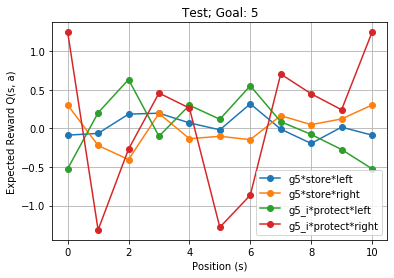

In [37]:
a = WmMazeAgent(NQLearningNetwork(1, 10), 10, (5,))
a.error()
a.plot("Test")

# Problem Solving

Below are some problem solving examples using the maze implementations defined above.

## Global Options

In [5]:
# Hard limit number of moves for a single episode
STEP_LIMIT = 100

## Utility Functions

In [6]:
# Calculate the optimal trace for the given goal
def optimalTraces(size, goal, discountFactor):
    trace = np.zeros(size)
    for i in range(1, size//2 + 1):
        trace[-i] = trace[i] = discountFactor*(trace[i-1] - 1)
    return np.array([np.roll(trace, goal + 1), np.roll(trace, goal - 1)])

## Standard Maze Agent

In [5]:
# Maze Settings
MAZE_SIZE = 20
GOAL      = 10

# Agent Settings
HRR_SIZE   = 64
LEARN_RATE = 0.05
EPSILON    = 0.2
DISCOUNT   = 0.95
COPY       = 10

# The agents (Q-learning, double Q-learning, deep Q-learning, double/deep Q-learning)
standardAgents = []
for hidden in ([], [HRR_SIZE//2]):
    for nQlearning in (1, 2):
        ql = NQLearningNetwork(nQlearning, HRR_SIZE, hiddenLayers=hidden, learnRate=LEARN_RATE, discountFactor=DISCOUNT, copyFrequency=COPY)
        standardAgents.append(MazeAgent(ql, MAZE_SIZE, GOAL))

Time: 705.89 seconds
Epoch: 10000
Error: 7.415921253664583
Progress: [####################] 100.00%
Using best error: 5.654661031504424 from epoch: 450


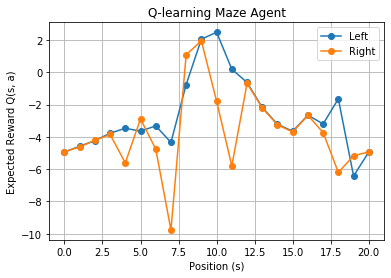

In [6]:
train("Q-learning Maze Agent", standardAgents[0], maxEpochs=10000, epsilon=EPSILON, simLimit=STEP_LIMIT, useBest = True)

Time: 376.36 seconds
Epoch: 10000
Error: 3.997899249147554
Progress: [####################] 100.00%
Using best error: 3.978414439550073 from epoch: 10000


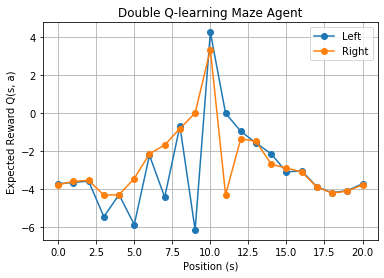

In [7]:
train("Double Q-learning Maze Agent", standardAgents[1], maxEpochs=10000, epsilon=EPSILON, simLimit=STEP_LIMIT, useBest = True)

Time: 218.53 seconds
Epoch: 10000
Error: 0.10373584829774972
Progress: [####################] 100.00%
Using best error: 0.07725243567315483 from epoch: 9900


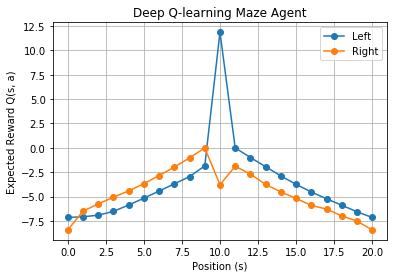

In [8]:
train("Deep Q-learning Maze Agent", standardAgents[2], maxEpochs=10000, epsilon=EPSILON, simLimit=STEP_LIMIT, useBest = True)

Time: 227.52 seconds
Epoch: 10000
Error: 0.04649745778947996
Progress: [####################] 100.00%
Using best error: 0.01333554395328547 from epoch: 8050


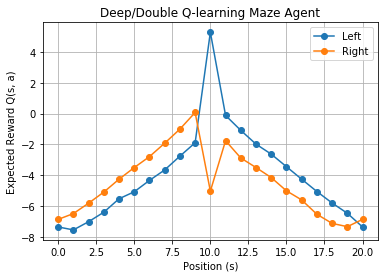

In [9]:
train("Deep/Double Q-learning Maze Agent", standardAgents[3], maxEpochs=10000, epsilon=EPSILON, simLimit=STEP_LIMIT, useBest = True)

# N-task Maze Agent

In [61]:
# Maze Settings
MAZE_SIZE = 20
GOALS = (2, 10, 17)

# Agent Settings
HRR_SIZE   = 192
LEARN_RATE = 0.2
EPSILON    = 0.2
DISCOUNT   = 0.95
COPY       = 50

nTaskAgents = []
for hidden in ([], [HRR_SIZE//2]):
    for nQlearning in (1, 2):
        ql = NQLearningNetwork(nQlearning, HRR_SIZE, hiddenLayers=hidden, learnRate=LEARN_RATE, discountFactor=DISCOUNT, copyFrequency=COPY)
        nTaskAgents.append(NMazeAgent(ql, MAZE_SIZE, GOALS))

Time: 70.32 seconds
Epoch: 10000
Error: 2.601596111781252
Progress: [####################] 100.00%
Using best error: 2.601596111781252 from epoch: 9963


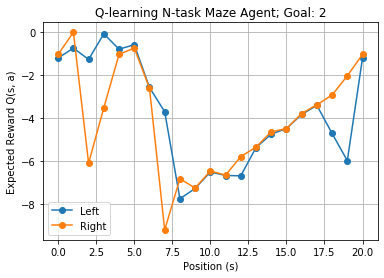

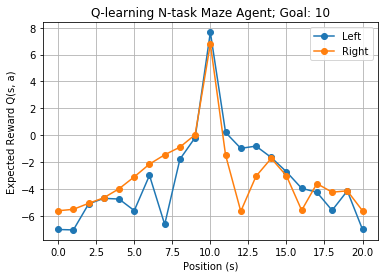

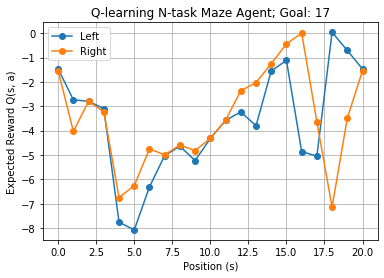

In [67]:
train("Q-learning N-task Maze Agent", nTaskAgents[0], maxError=0.1, maxEpochs=10000, epsilon=EPSILON, simLimit=STEP_LIMIT, useBest = True)

Time: 453.62 seconds
Epoch: 10000
Error: 2.828707048306351
Progress: [####################] 100.00%
Using best error: 2.828707048306351 from epoch: 9980


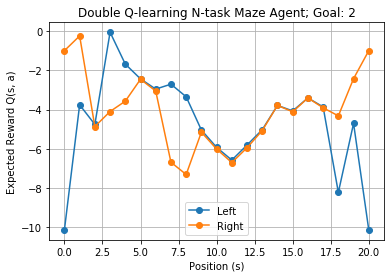

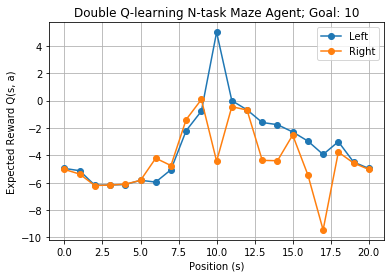

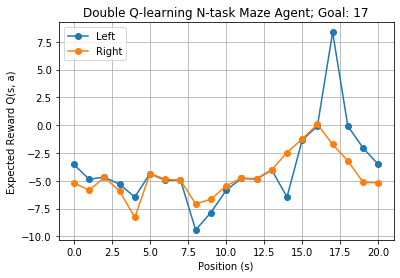

In [68]:
train("Double Q-learning N-task Maze Agent", nTaskAgents[1], maxEpochs=10000, epsilon=EPSILON, simLimit=STEP_LIMIT, useBest = True)

Time: 136.43 seconds
Epoch: 10000
Error: 0.1279355222979402
Progress: [####################] 100.00%
Using best error: 0.051499755632586214 from epoch: 7718


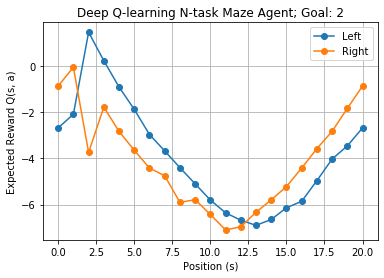

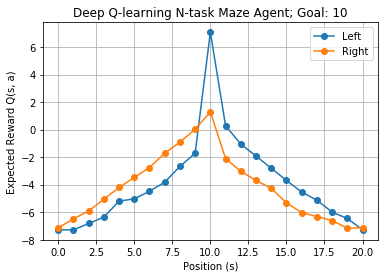

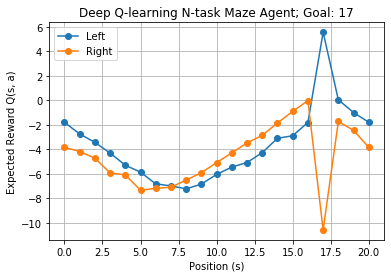

In [71]:
train("Deep Q-learning N-task Maze Agent", nTaskAgents[2], maxEpochs=10000, epsilon=EPSILON, simLimit=STEP_LIMIT, useBest = True)

Time: 125.99 seconds
Epoch: 10000
Error: 0.1519337276810371
Progress: [####################] 100.00%
Using best error: 0.08632136471954244 from epoch: 9481


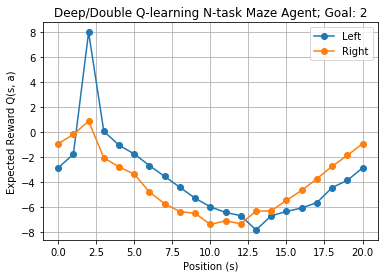

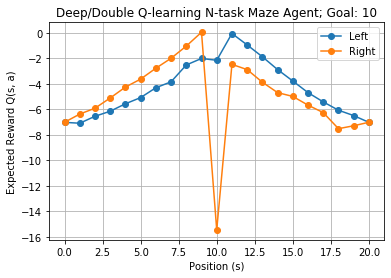

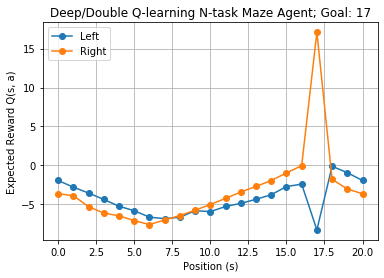

In [70]:
train("Deep/Double Q-learning N-task Maze Agent", nTaskAgents[3], maxEpochs=10000, epsilon=EPSILON, simLimit=STEP_LIMIT, useBest = True)

# Working Memory 1D-Maze

In [53]:
# Maze Settings
MAZE_SIZE = 20
GOALS = (0, 10)

# Agent Settings
HRR_SIZE   = 4096
LEARN_RATE = 1.0
EPSILON    = 0.2
DISCOUNT   = 0.95
COPY       = 300

# Shown to converge with Size=10, Learn=1, HRR=4096, Epsilon=0.3, Discount=0.5
# Shown to converge with Size=20, Learn=1, HRR=4096, Epsilon=0.25, Discount=0.75

# Deep learning *converged* 4096, 1.0, 0.2, 0.95, 300

wmAgents = []
for hidden in ([], [HRR_SIZE//2]):
    for nQlearning in (1, 2):
        ql = NQLearningNetwork(nQlearning, HRR_SIZE, hiddenLayers=hidden, learnRate=LEARN_RATE, discountFactor=DISCOUNT, copyFrequency=COPY)
        wmAgents.append(WmMazeAgent(ql, MAZE_SIZE, GOALS))

Time: 876.04 seconds
Epoch: 10000
Error: 1.1294653923191187
Progress: [####################] 100.00%


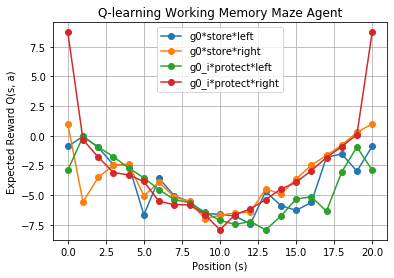

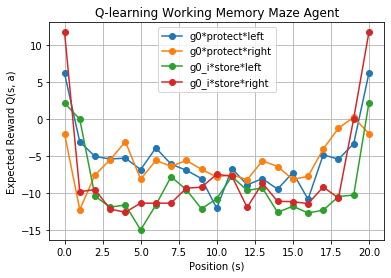

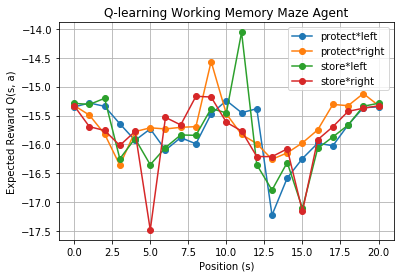

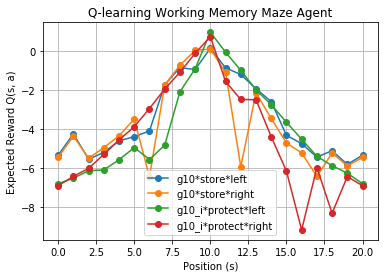

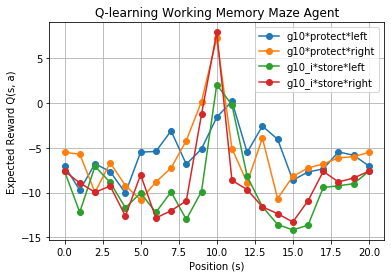

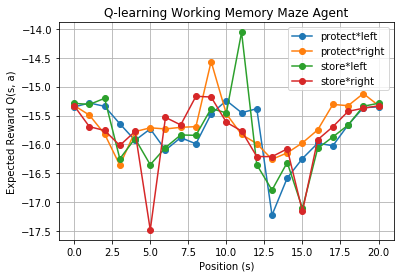

In [212]:
train("Q-learning Working Memory Maze Agent", wmAgents[0], maxEpochs=10000, epsilon=EPSILON, simLimit=STEP_LIMIT, useBest = False)

Time: 1096.81 seconds
Epoch: 10000
Error: 0.6563258826603714
Progress: [####################] 100.00%


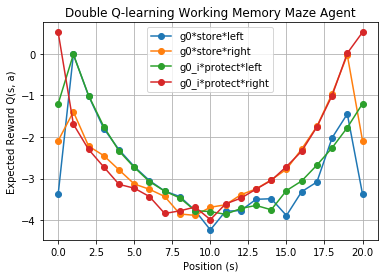

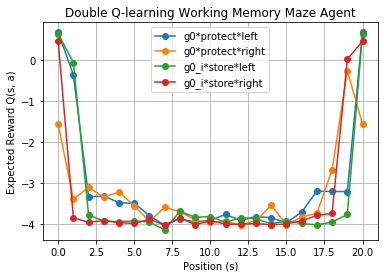

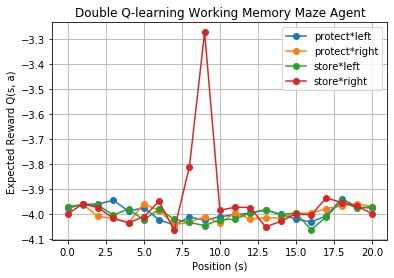

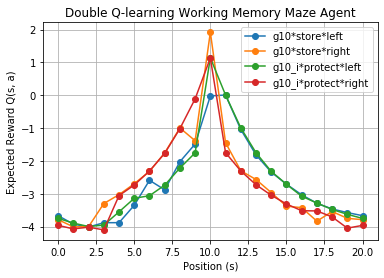

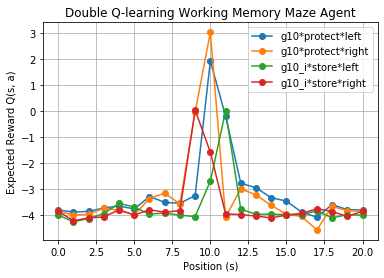

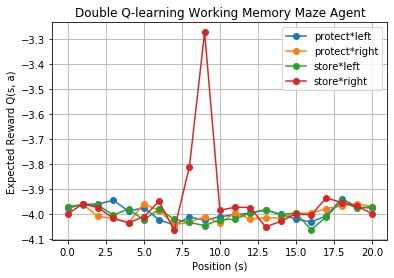

In [150]:
train("Double Q-learning Working Memory Maze Agent", wmAgents[1], maxEpochs=10000, epsilon=EPSILON, simLimit=STEP_LIMIT, useBest = False)

Time: 150.79 seconds
Epoch: 10000
Error: 0.6048592501920383
Progress: [####################] 100.00%
Using best error: 0.45039333910253776 from epoch: 0


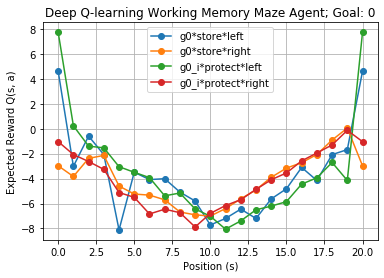

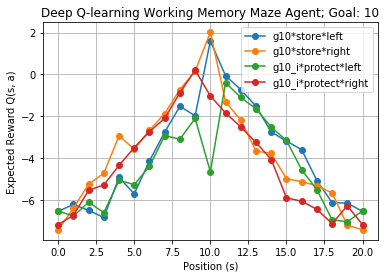

In [55]:
train("Deep Q-learning Working Memory Maze Agent", wmAgents[2], maxEpochs=10000, epsilon=EPSILON, simLimit=STEP_LIMIT, useBest=True)

In [ ]:
train("Double/Deep Q-learning Working Memory Maze Agent", wmAgents[2], maxEpochs=10000, epsilon=EPSILON, simLimit=STEP_LIMIT, useBest = False)

Time: 23.20 seconds
Epoch: 47
Error: 4.873109768969512
Progress: [--------------------] 0.47%
